In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Cyclegan

The code came from [here](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix). 
We can compare the relevant bits of fast.ai written in a different way by somebody else:
how they do datasets, data loaders, models, training loops, etc.
The code is in the `cgan` directory [2:02:12] 
(nearly the original with some cleanups which JH will submit as a PR). 
Originally written for a sscript (rather than notebook), JH cleaned it up.

In [3]:
from fastai.conv_learner import *
from fastai.dataset import *

In [4]:
torch.cuda.set_device(0)

In [5]:
from cgan.options.train_options import *

In [6]:
#! wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip

So cgan is their github code with minor changes. 
The way cgan mini library has been set up is that the configuration options, they are assuming, are being passed into like a script. 
So they have TrainOptions().parse method and I’m basically passing in an array of script options (where’s my data, how many threads, do I want to dropout, how many iterations, what am I going to call this model, which GPU do I want run it on). 
That gives us an opt object which you can see what it contains. 
It contains defaults for other things we didn’t mention.

In [7]:
opt = TrainOptions().parse(['--dataroot', '/data/horse2zebra', '--nThreads', '8', '--no_dropout',
                           '--niter', '100', '--niter_decay', '100', '--name', 'nodrop', '--gpu_ids', '0'])

------------ Options -------------
batchSize: 1
beta1: 0.5
checkpoints_dir: ./checkpoints
continue_train: False
dataroot: /data/horse2zebra
dataset_mode: unaligned
display_freq: 100
display_id: 1
display_port: 8097
display_single_pane_ncols: 0
display_winsize: 256
epoch_count: 1
fineSize: 256
gpu_ids: [0]
init_type: normal
input_nc: 3
isTrain: True
lambda_A: 10.0
lambda_B: 10.0
lambda_identity: 0.5
loadSize: 286
lr: 0.0002
lr_decay_iters: 50
lr_policy: lambda
max_dataset_size: inf
model: cycle_gan
nThreads: 8
n_layers_D: 3
name: nodrop
ndf: 64
ngf: 64
niter: 100
niter_decay: 100
no_dropout: True
no_flip: False
no_html: False
no_lsgan: False
norm: instance
output_nc: 3
phase: train
pool_size: 50
print_freq: 100
resize_or_crop: resize_and_crop
save_epoch_freq: 5
save_latest_freq: 5000
serial_batches: False
update_html_freq: 1000
which_direction: AtoB
which_epoch: latest
which_model_netD: basic
which_model_netG: resnet_9blocks
-------------- End ----------------


We use the cgan library (not fast.ai).

In [8]:
from cgan.options.train_options import TrainOptions
from cgan.data.data_loader import CreateDataLoader
from cgan.models.models import create_model

We create a data loader with `CreateDataLoader`. (Use VSCode to find symbol to go to CreateDataLoader.)
It creates a `CustomDatasetDataLoader`, a `BaseDataLoader`, to use a standard PyTorch DataLoader.
```
def CreateDataLoader(opt):
    data_loader = CustomDatasetDataLoader()
    print(data_loader.name())
    data_loader.initialize(opt)
    return data_loader
```

A standard PyTorch DataLoader gets a dataset (contains a length and an indexer.)

`CreateDataset` does more than just cycle GAN — it handles both aligned and unaligned image pairs [2:04:46]. 
Our image pairs are unaligned so we are going to UnalignedDataset.

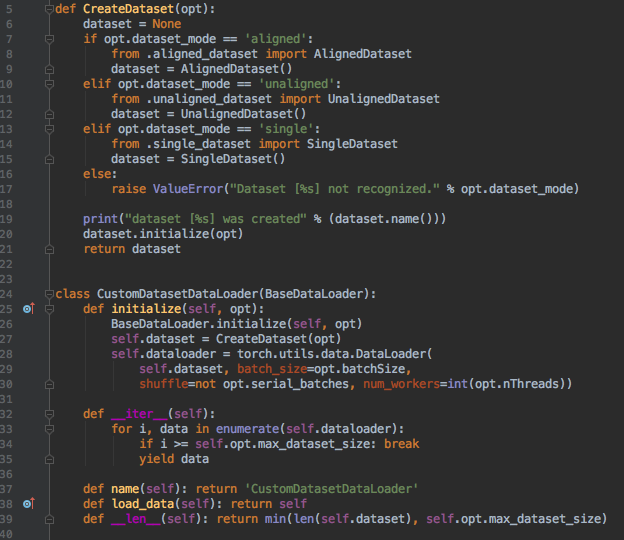

As expected, `UnalignedDataset(BaseDataset)` has __getitem__ and __len__. 
For length, A and B are our horses and zebras, we got two sets, 
so whichever one is longer is the length of the DataLoader.
```
def __len__(self): return max(self.A_size, self.B_size)
```

` __getitem__` is going to:

- Grab images from each of the datasets (horses and zebras)  (Randomly sometimes?)
- Open them up with pillow (PIL)
- Run them through some transformations
- Then either turn horses into zebras or zebras into horses, so there is direction
- Return our horse, zebra, a path to the horse, and a path of zebra
```
return {'A': A, 'B': B, 'A_paths': A_path, 'B_paths': B_path}
```
Fast.ai does more transforms and performance, but this is good research code for this one thing. 

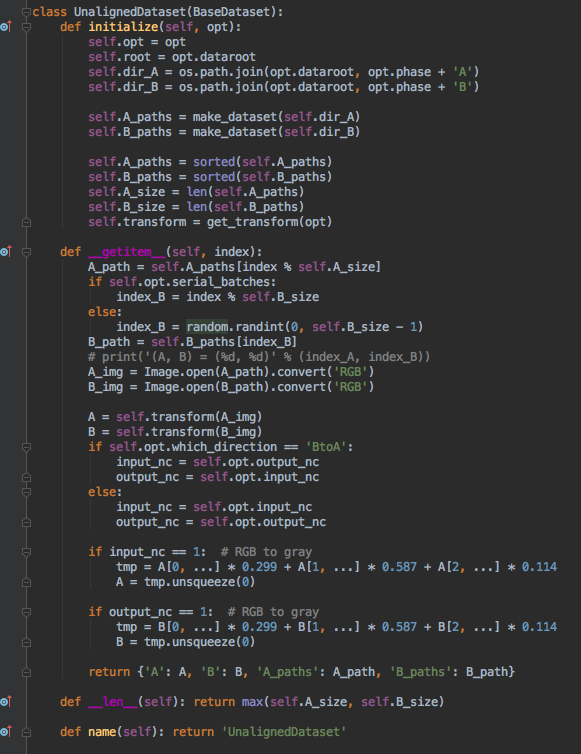

In [9]:
data_loader = CreateDataLoader(opt)

CustomDatasetDataLoader
dataset [UnalignedDataset] was created


/home/german/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


We have `data_loader`, lets load the data into it [2:06:17]. 
len(data_loader) will tell us how many mini-batches are in it (the length of the data loader in PyTorch).

In [10]:
dataset = data_loader.load_data()
dataset_size = len(data_loader)  ; print("Mini-batches:", dataset_size)

Mini-batches: 1334


## Create a model
Next step is to create a model. 
Same idea, we’ve got different kind of models and we’re going to be doing a cycle GAN.

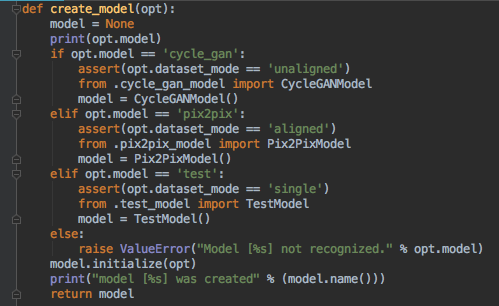

Here is the `CycleGANModel`, let’s go through it and find out what’s going to be used. 
First we called initializer so it’s going to go through and define two generators (for horses and zebras). 
There is some way for it to generate a pool of fake data and then we’re going to grab our GAN loss.
Cycle-consistency loss is an L1 loss. 
They use Adam.  
Then we are going to have:
- an optimizer for our horse discriminator, 
- an optimizer for our zebra discriminator, 
- and an optimizer for the generator, which will contain the parameters for both horse and zebra generators, all in one place.

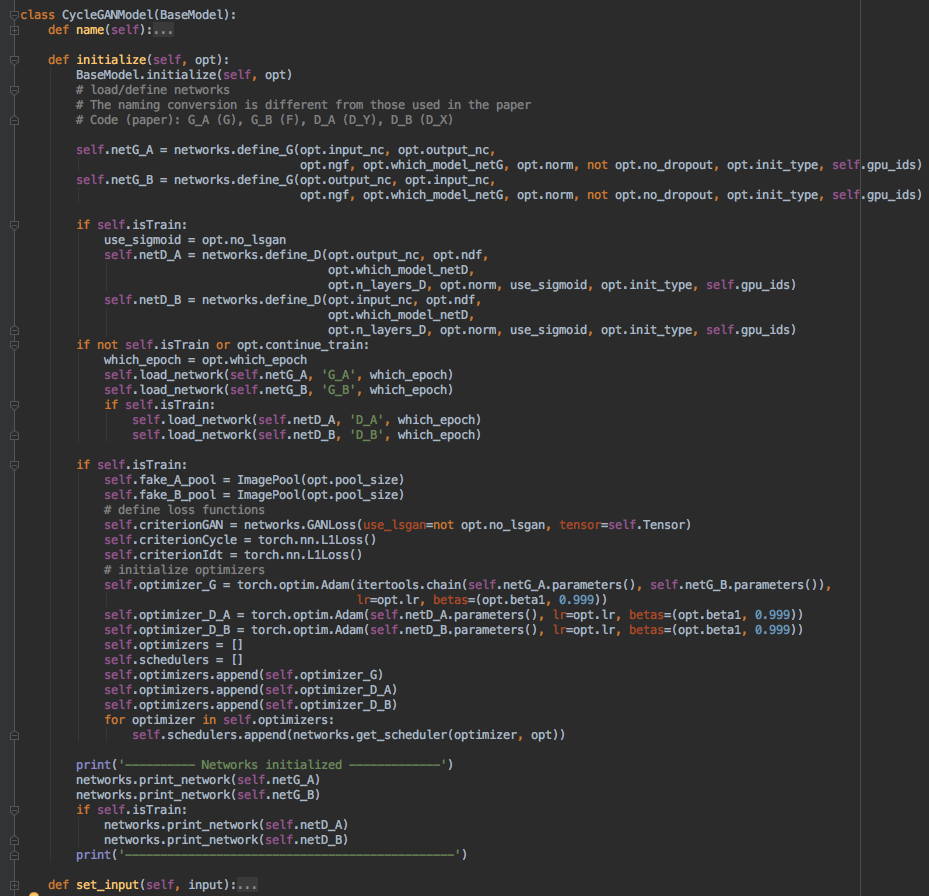

So the initializer is going to set up all of the different networks and loss functions we need and they are going to be stored inside this model [2:08:14].

In [11]:
model = create_model(opt)

cycle_gan
initialization method [normal]
initialization method [normal]
initialization method [normal]
initialization method [normal]
---------- Networks initialized -------------
ResnetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d (3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False)
    (3): ReLU(inplace)
    (4): Conv2d (64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False)
    (6): ReLU(inplace)
    (7): Conv2d (128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False)
    (9): ReLU(inplace)
    (10): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False)
        (3): ReLU(i

Above it shows their PyTorch model.  
- They use ResNets (conv2d, InstanceNorm2D ($\approx batchnorm$), Relu). 
- `InstanceNorm` is like batchnorm but applies to one image at a time (non-important difference). 
- They also do reflection padding. 

In [10]:
# opt.niter=9
# opt.niter_decay=1

The model contains the loss functions, generators, discriminators, all in one convenient place [2:09:32]. 
JH refactored the training to run it inside the notebook. <br>
A loop to go through each epoch, and a loop to go through the data.<br> 

Before we set up dataset, but it is not a PyTorch dataset.
This is what they used (slightly confusingly) to talk about their combined (we would call it a model data object), 
— all the data that they need. 
Loop through that with `tqdm` to get a progress bar.
Now let's see what happens in the model.

In [12]:
total_steps = 0

for epoch in range(opt.epoch_count, opt.niter + opt.niter_decay + 1):
    epoch_start_time = time.time()
    iter_data_time = time.time()
    epoch_iter = 0

    for i, data in tqdm(enumerate(dataset)):
        iter_start_time = time.time()
        if total_steps % opt.print_freq == 0: t_data = iter_start_time - iter_data_time
        total_steps += opt.batchSize
        epoch_iter += opt.batchSize
        model.set_input(data)
        model.optimize_parameters()

        if total_steps % opt.display_freq == 0:
            save_result = total_steps % opt.update_html_freq == 0

        if total_steps % opt.print_freq == 0:
            errors = model.get_current_errors()
            t = (time.time() - iter_start_time) / opt.batchSize

        if total_steps % opt.save_latest_freq == 0:
            print('saving the latest model (epoch %d, total_steps %d)' % (epoch, total_steps))
            model.save('latest')

        iter_data_time = time.time()
    if epoch % opt.save_epoch_freq == 0:
        print('saving the model at the end of epoch %d, iters %d' % (epoch, total_steps))
        model.save('latest')
        model.save(epoch)

    print('End of epoch %d / %d \t Time Taken: %d sec' %
          (epoch, opt.niter + opt.niter_decay, time.time() - epoch_start_time))
    model.update_learning_rate()

1334it [11:37,  1.91it/s]
End of epoch 1 / 200 	 Time Taken: 697 sec
learning rate = 0.0002000
1334it [11:37,  1.91it/s]
End of epoch 2 / 200 	 Time Taken: 697 sec
learning rate = 0.0002000
1334it [11:37,  1.91it/s]
End of epoch 3 / 200 	 Time Taken: 697 sec
learning rate = 0.0002000
997it [08:41,  1.91it/s]saving the latest model (epoch 4, total_steps 5000)
1334it [11:37,  1.91it/s]
End of epoch 4 / 200 	 Time Taken: 697 sec
learning rate = 0.0002000
1334it [11:37,  1.91it/s]
saving the model at the end of epoch 5, iters 6670
End of epoch 5 / 200 	 Time Taken: 698 sec
learning rate = 0.0002000
1334it [11:37,  1.91it/s]
End of epoch 6 / 200 	 Time Taken: 697 sec
learning rate = 0.0002000
1334it [11:37,  1.91it/s]
End of epoch 7 / 200 	 Time Taken: 697 sec
learning rate = 0.0002000
661it [05:45,  1.91it/s]saving the latest model (epoch 8, total_steps 10000)
1334it [11:37,  1.91it/s]
End of epoch 8 / 200 	 Time Taken: 697 sec
learning rate = 0.0002000
1334it [11:37,  1.91it/s]
End of epo

1334it [11:43,  1.90it/s]
End of epoch 66 / 200 	 Time Taken: 703 sec
learning rate = 0.0002000
1334it [11:43,  1.90it/s]
End of epoch 67 / 200 	 Time Taken: 703 sec
learning rate = 0.0002000
621it [05:27,  1.89it/s]saving the latest model (epoch 68, total_steps 90000)
1334it [11:44,  1.89it/s]
End of epoch 68 / 200 	 Time Taken: 704 sec
learning rate = 0.0002000
1334it [11:44,  1.89it/s]
End of epoch 69 / 200 	 Time Taken: 704 sec
learning rate = 0.0002000
1334it [11:44,  1.89it/s]
saving the model at the end of epoch 70, iters 93380
End of epoch 70 / 200 	 Time Taken: 704 sec
learning rate = 0.0002000
1334it [11:44,  1.89it/s]
End of epoch 71 / 200 	 Time Taken: 704 sec
learning rate = 0.0002000
285it [02:30,  1.89it/s]saving the latest model (epoch 72, total_steps 95000)
1334it [11:45,  1.89it/s]
End of epoch 72 / 200 	 Time Taken: 705 sec
learning rate = 0.0002000
1334it [11:44,  1.89it/s]
End of epoch 73 / 200 	 Time Taken: 704 sec
learning rate = 0.0002000
1334it [11:45,  1.89it/

1334it [11:38,  1.91it/s]
saving the model at the end of epoch 130, iters 173420
End of epoch 130 / 200 	 Time Taken: 698 sec
learning rate = 0.0001386
1334it [11:38,  1.91it/s]
End of epoch 131 / 200 	 Time Taken: 698 sec
learning rate = 0.0001366
245it [02:08,  1.90it/s]saving the latest model (epoch 132, total_steps 175000)
1334it [11:38,  1.91it/s]
End of epoch 132 / 200 	 Time Taken: 698 sec
learning rate = 0.0001347
1334it [11:38,  1.91it/s]
End of epoch 133 / 200 	 Time Taken: 698 sec
learning rate = 0.0001327
1334it [11:38,  1.91it/s]
End of epoch 134 / 200 	 Time Taken: 698 sec
learning rate = 0.0001307
1243it [10:50,  1.91it/s]saving the latest model (epoch 135, total_steps 180000)
1334it [11:38,  1.91it/s]
saving the model at the end of epoch 135, iters 180090
End of epoch 135 / 200 	 Time Taken: 698 sec
learning rate = 0.0001287
1334it [11:39,  1.91it/s]
End of epoch 136 / 200 	 Time Taken: 699 sec
learning rate = 0.0001267
1334it [11:38,  1.91it/s]
End of epoch 137 / 200 	

1334it [11:43,  1.90it/s]
End of epoch 193 / 200 	 Time Taken: 703 sec
learning rate = 0.0000139
1334it [11:42,  1.90it/s]
End of epoch 194 / 200 	 Time Taken: 702 sec
learning rate = 0.0000119
1203it [10:33,  1.90it/s]saving the latest model (epoch 195, total_steps 260000)
1334it [11:42,  1.90it/s]
saving the model at the end of epoch 195, iters 260130
End of epoch 195 / 200 	 Time Taken: 703 sec
learning rate = 0.0000099
1334it [11:42,  1.90it/s]
End of epoch 196 / 200 	 Time Taken: 702 sec
learning rate = 0.0000079
1334it [11:42,  1.90it/s]
End of epoch 197 / 200 	 Time Taken: 702 sec
learning rate = 0.0000059
1334it [11:42,  1.90it/s]
End of epoch 198 / 200 	 Time Taken: 702 sec
learning rate = 0.0000040
867it [07:35,  1.90it/s]saving the latest model (epoch 199, total_steps 265000)
1334it [11:41,  1.90it/s]
End of epoch 199 / 200 	 Time Taken: 701 sec
learning rate = 0.0000020
1334it [11:41,  1.90it/s]
saving the model at the end of epoch 200, iters 266800
End of epoch 200 / 200 	

`set_input` [2:10:32]: 
It’s a different approach (than fast.ai). 
It’s quite specific to cycle GANs.  
Inside the model we are going to go into our data and grab the appropriate one. 
We are either going horse to zebra or zebra to horse.
Depending on which way we go, A is either horse or zebra, and vice versa. 
If necessary put it on the appropriate GPU, then grab the appropriate paths. 
So the model now has a mini-batch of horses and a mini-batch of zebras.
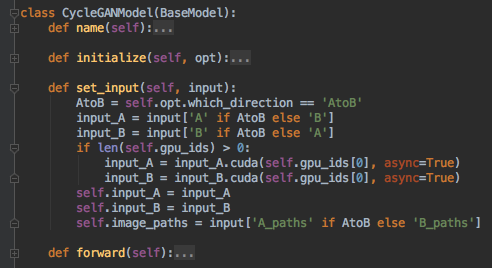

Now we optimize the parameters [2:11:19]. 
- First, optimize the generators, 
- then try to optimize the horse discriminators, 
- then try to optimize the zebra discriminator. 

zero_grad() is a part of PyTorch, as well as step(). 
The interesting bit is the actual thing that does the back propagation on the generator.
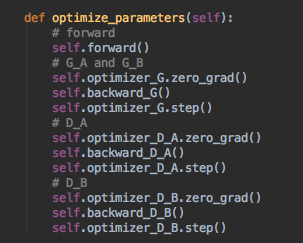

Here it is [2:12:04]. 
There’s all the formula from the paper. 
- take a horse and generate a zebra. 
- use the discriminator to see if we can tell whether it’s fake or not (pred_fake). 
- pop that into our loss function (which we set up earlier to get a GAN loss based on that prediction). 
- Let’s do the same thing going the opposite direction using the opposite discriminator then put that through the loss function again. 
- Then let’s do the cycle consistency loss. 
- Again, we take our fake which we created and try and turn it back again into the original. 
- Let’s use the cycle consistency loss function we created earlier to compare it to the real original. 
And here is that lambda — so there’s some weight that we used and that would set up actually we just use the default that they suggested in their options. 
- Then do the same for the opposite direction and then add them all together. 
- We then do the backward step. 
That’s it.

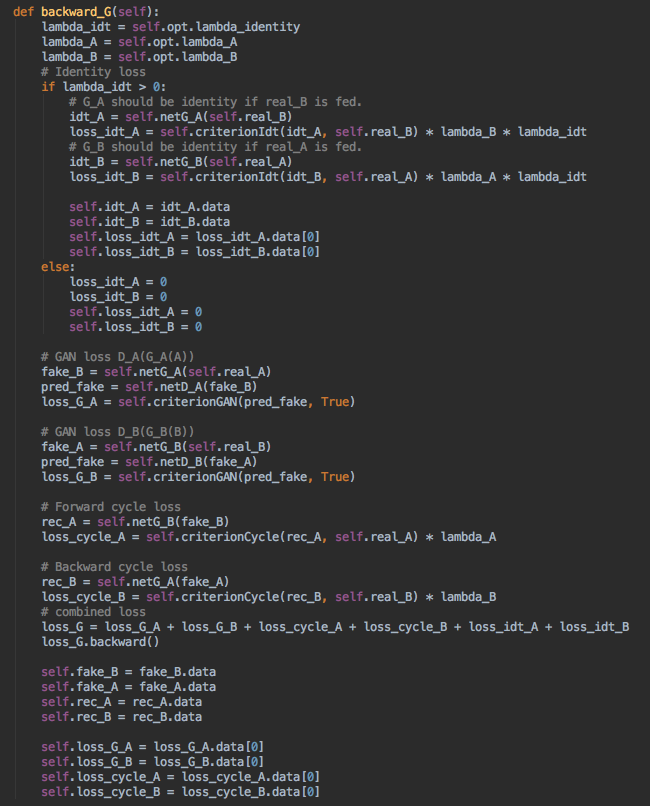

So we can do the same thing for the first discriminator [2:13:50]. 
Since basically all the work has been done now, there’s much less to do here, it’s basically 
the same basic stuff that we’ve already seen.
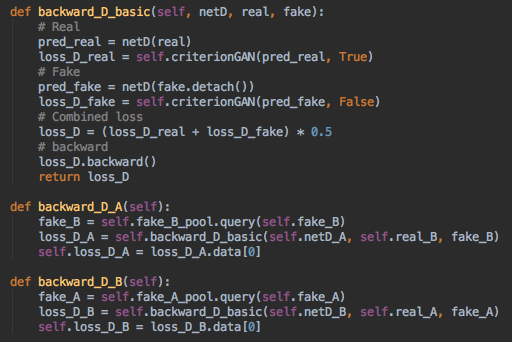

`optimize_parameters()` is calculating the losses and doing the optimizer step. 
From time to time, save and print out some results. 
Then from time to time, update the learning rate so they’ve got some learning rate annealing built in here as well. Kind of like fast.ai, they’ve got this idea of schedulers which you can then use to update your learning rates.
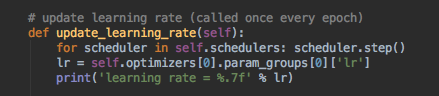

This is interesting to better understand DL APIs,get a sense for how they are solving problems,  similarities/differences, etc.

In [13]:
def show_img(im, ax=None, figsize=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [14]:
def get_one(data):
    model.set_input(data)
    model.test()
    return list(model.get_current_visuals().values())

In [15]:
model.save(201)

In [16]:
test_ims = []
for i,o in enumerate(dataset):
    if i>10: break
    test_ims.append(get_one(o))

In [17]:
def show_grid(ims):
    fig,axes = plt.subplots(2,3,figsize=(9,6))
    for i,ax in enumerate(axes.flat): show_img(ims[i], ax);
    fig.tight_layout()

We train that for a little while and then we can just grab a few examples and here we have them [2:15:29]. Here are horses, zebras, and back again as horses.

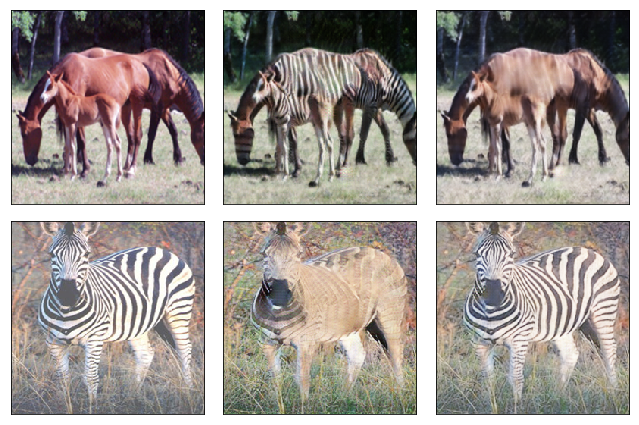

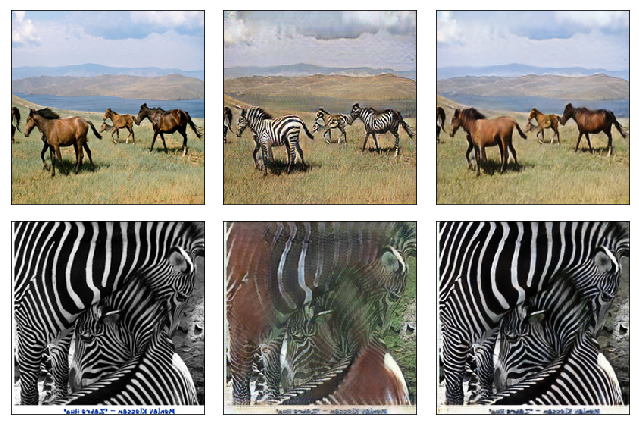

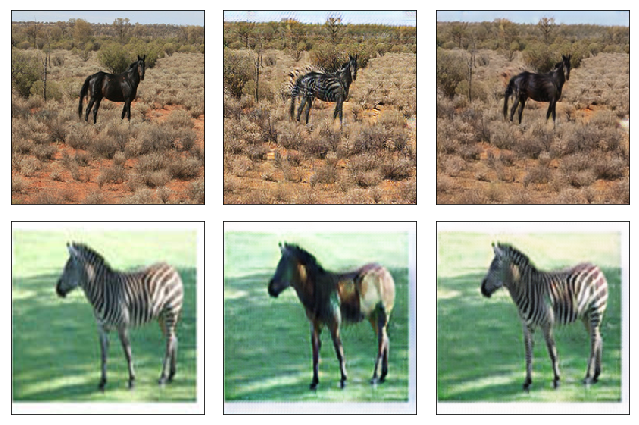

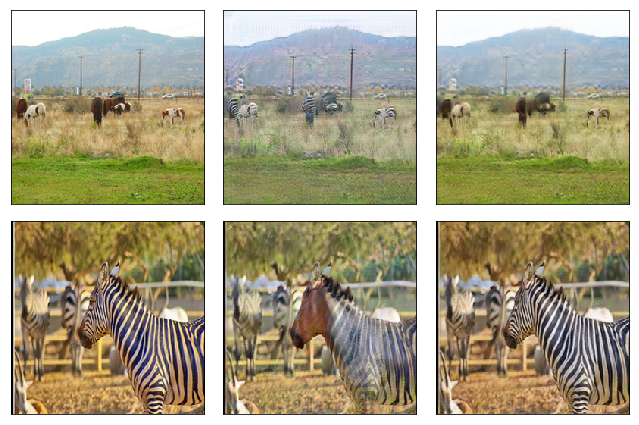

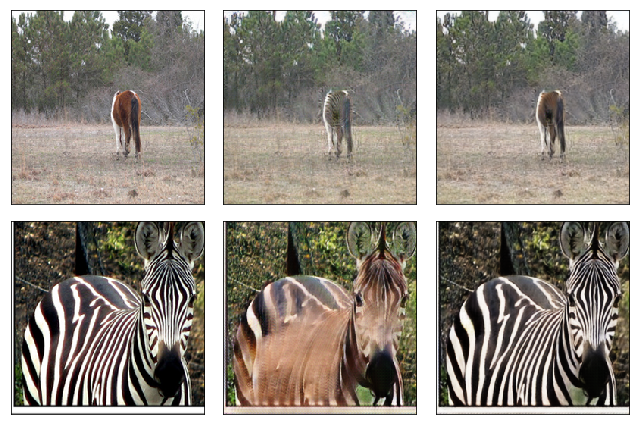

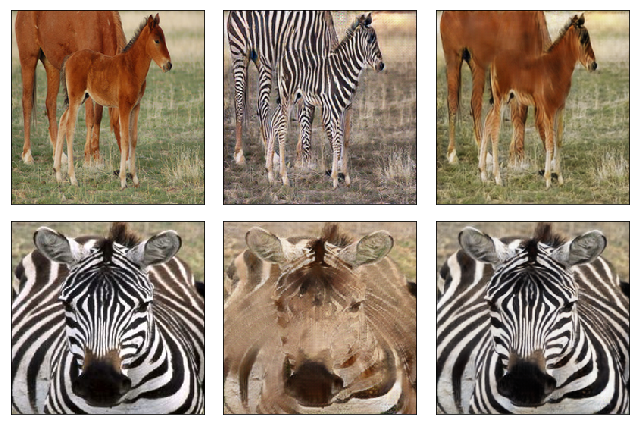

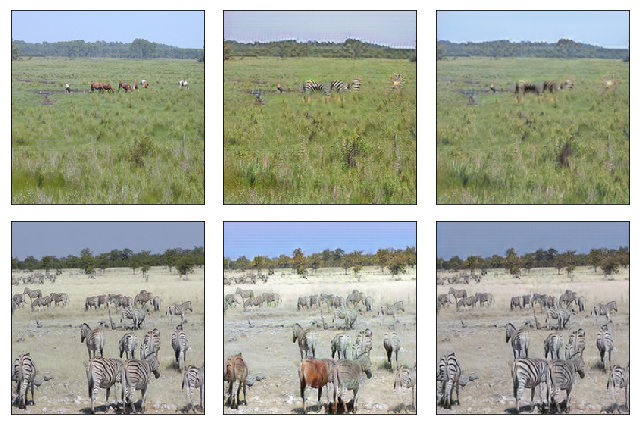

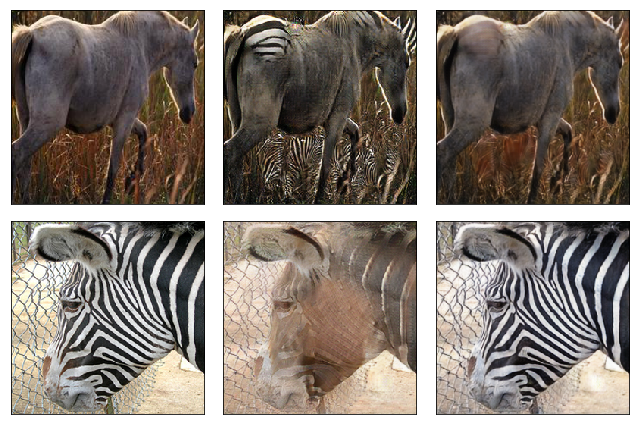

In [20]:
for i in range(8): show_grid(test_ims[i])

It took 24 hours to train it even that far so it’s kind of slow [2:16:39]. 

## fin